In [2]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt

## Loading data

In [3]:
data = './D128_timeseries_ERA5_demErr.h5'
mask = './D128_maskTempCoh.h5'

filename = os.path.basename(data)
maskfile = h5py.File(mask, 'r')
datafile = h5py.File(data, 'r')

mask = np.array(maskfile['mask'])
ts_allregion = np.array(datafile['timeseries'])
dates = np.array([d.decode("utf-8") for d in datafile['date']])

# Applying mask
#for i, fr in enumerate(ts_allregion):
#    ts_allregion[i] = np.where(mask, ts_allregion[i], np.nan)

Selecting ROI around volcano

In [4]:
nt = ts_allregion.shape[0]
timeseries = np.zeros((nt, 400, 400))
for i, fr in enumerate(ts_allregion):
    timeseries[i] = fr[660:1060, 620:1020]

Example 2D time series for reference

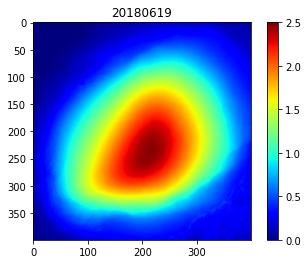

In [6]:
plt.figure()
plt.title(dates[97])
plt.imshow(timeseries[97, :, :], vmin=0, vmax=2.5, cmap='jet')
plt.colorbar()
plt.show()

## Extracting region masks
### Image Segmentation

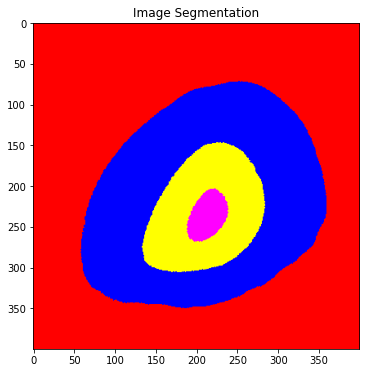

In [7]:
from skimage.color import label2rgb
import cv2

last_fr = timeseries[97, :, :].copy()

# Making center region more evident for segmentation
for y in range(400):
    for x in range(400):
        if (last_fr[y, x] > 2.4):
            last_fr[y, x] = 5

# Splitting and Visualizing segmented regions
regions = label2rgb(last_fr, bg_label=0)
regions = regions.astype(np.uint8) * 255

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Image Segmentation')
ax.imshow(regions)

### Masks

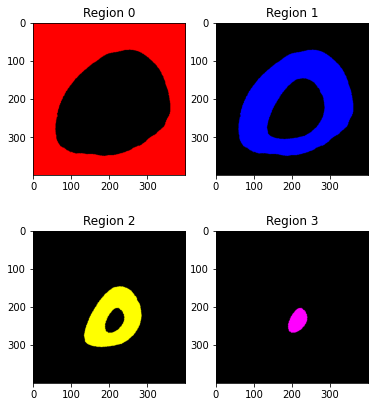

In [9]:
import cv2

## Extracting masks
regions_hsv = cv2.cvtColor(regions, cv2.COLOR_RGB2HSV)

# Red mask
lower_red = np.array([0,50,20])
upper_red = np.array([10,255,255])
mask0 = cv2.inRange(regions_hsv, lower_red, upper_red)
mask0viz = cv2.merge((mask0, mask0, mask0))

# Blue mask
lower_blue = np.array([112, 50, 20])
upper_blue = np.array([128, 255, 255])
mask1 = cv2.inRange(regions_hsv, lower_blue, upper_blue)
mask1viz = cv2.merge((mask1, mask1, mask1))

# Yellow mask
lower_yellow = np.array([28, 50, 20])
upper_yellow = np.array([32, 255, 255])
mask2 = cv2.inRange(regions_hsv, lower_yellow, upper_yellow)
mask2viz = cv2.merge((mask2, mask2, mask2))

# Magenta mask
lower_magenta = np.array([140, 50, 20])
upper_magenta = np.array([160, 255, 255])
mask3 = cv2.inRange(regions_hsv, lower_magenta, upper_magenta)
mask3viz = cv2.merge((mask3, mask3, mask3))

# Visualizing
fig, axs = plt.subplots(2, 2, figsize=(6, 7))
thrs = np.bitwise_and(mask0viz, regions)
axs[0, 0].set_title('Region 0')
axs[0, 0].imshow(thrs)

thrs = np.bitwise_and(mask1viz, regions)
axs[0, 1].set_title('Region 1')
axs[0, 1].imshow(thrs)

thrs = np.bitwise_and(mask2viz, regions)
axs[1, 0].set_title('Region 2')
axs[1, 0].imshow(thrs)

thrs = np.bitwise_and(mask3viz, regions)
axs[1, 1].set_title('Region 3')
axs[1, 1].imshow(thrs)

## Splitting Data
Splitting data into four 1D time series according to segmented regions. 
Values within each region are averaged per frame

In [10]:
nt = timeseries.shape[0]
#series0 = np.zeros((nt))
series1 = np.zeros((nt))
series2 = np.zeros((nt))
series3 = np.zeros((nt))

#mask0 = mask0.astype(bool)
mask1 = mask1.astype(bool)
mask2 = mask2.astype(bool)
mask3 = mask3.astype(bool)

for t in range(0, nt):
    fr = np.array(timeseries[t, :, :].copy())
    
    m = np.ma.masked_where(mask0==True, fr) 
    pix_values = np.ma.compressed(m)
    #series0[t] = np.nanmean(pix_values)
    
    m = np.ma.masked_where(mask1==True, fr) 
    pix_values = np.ma.compressed(m)
    series1[t] = np.nanmean(pix_values)
    
    m = np.ma.masked_where(mask2==True, fr) 
    pix_values = np.ma.compressed(m)
    series2[t] = np.nanmean(pix_values)
    
    m = np.ma.masked_where(mask3==True, fr) 
    pix_values = np.ma.compressed(m)
    series3[t] = np.nanmean(pix_values)
    

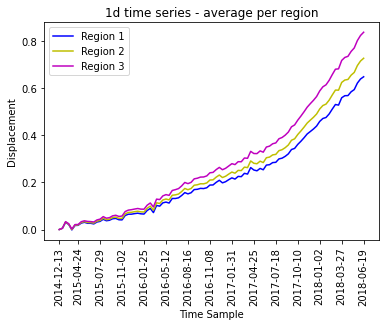

In [11]:
def get_ticks_and_labels(val_range, n_ticks, start_date_idx):  
    xticks_pos = np.linspace(val_range[0], val_range[1], n_ticks, dtype='int')
    xticks_labels = [datafile['date'][i+start_date_idx].decode("utf-8") for i in xticks_pos]
    xticks_labels_dash = [f"{t[:4]}-{t[4:6]}-{t[6:]}" for t in xticks_labels]
    return xticks_pos, xticks_labels_dash

plt.cla()
#plt.plot(series0, 'r-', label='Region 0')
plt.plot(series1, 'b-', label='Region 1')
plt.plot(series2, 'y-', label='Region 2')
plt.plot(series3, 'm-', label='Region 3')
plt.ylabel('Displacement')
plt.xlabel('Time Sample')
xticks_pos, xticks_labels = get_ticks_and_labels([0, nt-1], 15, 0)
plt.xticks(xticks_pos, xticks_labels, rotation='vertical')
plt.title('1d time series - average per region')
plt.legend()
plt.show()

series_all = [series1, series2, series3]

## Arima

In [12]:
from statsmodels.tsa.arima_model import ARIMA

def train_arima(series, split_idx):
    '''
        Trains arima model by splitting data at index 'split_idx'
    '''
    models = []
    for serie in series:
        train_serie = serie[:split_idx]
        model = ARIMA(train_serie, order=(5, 2, 0))
        
        try:
            model_fit = model.fit(disp=0)
            models.append(model_fit)
        except:
            models.append(np.nan)
            
    return models

def forecast_arima(series, models, wait_steps):
    '''
        Returns next step prediction for all series on list 'series'
    '''
    preds = []
    for serie, model in zip(series, models):
        try:
            yhat = model.forecast(wait_steps)[0]
        except:
            yhat = [np.nan] * wait_steps
        preds.append(yhat)
    return preds

def get_true_values(series, idx, wait_steps):
    '''
        Returns series value at index 'idx'
    '''
    true = []
    for serie in series:
        true.append(serie[idx:idx+wait_steps])
    return true

Training models

In [13]:
split_init = 46 # Splits end of 2016
split_end = len(series1)
wait_steps = 12

diff_reg1, diff_reg2, diff_reg3 = [], [], []
pred_reg1, pred_reg2, pred_reg3 = [], [], []

for idx in range(split_init, split_end):
    if ((idx % wait_steps) == 0):
        models = train_arima(series_all, idx)
        preds = forecast_arima(series_all, models, wait_steps)
        true = get_true_values(series_all, idx, wait_steps)
        
        pred0 = preds[0][:len(true[0])]
        pred1 = preds[1][:len(true[1])]
        pred2 = preds[2][:len(true[2])]
        
        pred_reg1.append(pred0)
        pred_reg2.append(pred1)
        pred_reg3.append(pred2)
        
        diff_reg1.append(np.array(true[0]-pred0))
        diff_reg2.append(np.array(true[1]-pred1))
        diff_reg3.append(np.array(true[2]-pred2))

# Flattening lists
pred_reg1 = np.concatenate(pred_reg1).ravel()
pred_reg2 = np.concatenate(pred_reg2).ravel()
pred_reg3 = np.concatenate(pred_reg3).ravel()

diff_reg1 = np.concatenate(diff_reg1).ravel()
diff_reg2 = np.concatenate(diff_reg2).ravel()
diff_reg3 = np.concatenate(diff_reg3).ravel()


/home/parallels/dev/arima-pge/venv/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Observed vs. Predicted Results

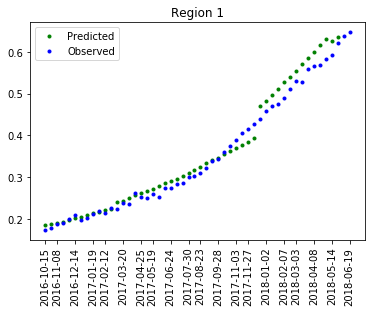

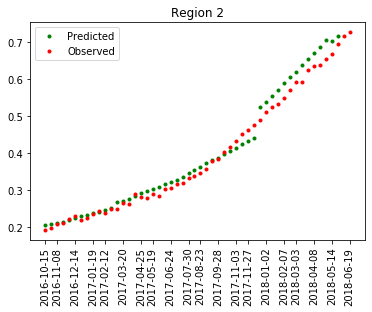

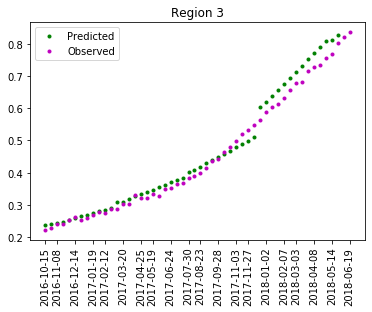

In [11]:
plt.cla()
plt.plot(pred_reg1, 'g.', series1[split_init:], 'b.')
xticks_pos, xticks_labels = get_ticks_and_labels([0, split_end-split_init-1], 20, split_init)
plt.xticks(xticks_pos, xticks_labels, rotation='vertical')
plt.legend(['Predicted', 'Observed'])
plt.title('Region 1')
plt.show()

plt.cla()
plt.plot(pred_reg2, 'g.', series2[split_init:], 'r.')
xticks_pos, xticks_labels = get_ticks_and_labels([0, split_end-split_init-1], 20, split_init)
plt.xticks(xticks_pos, xticks_labels, rotation='vertical')
plt.legend(['Predicted', 'Observed'])
plt.title('Region 2')
plt.show()

plt.cla()
plt.plot(pred_reg3, 'g.', series3[split_init:], 'm.')
xticks_pos, xticks_labels = get_ticks_and_labels([0, split_end-split_init-1], 20, split_init)
plt.xticks(xticks_pos, xticks_labels, rotation='vertical')
plt.legend(['Predicted', 'Observed'])
plt.title('Region 3')
plt.show()

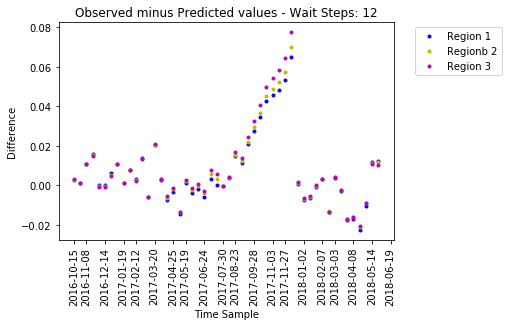

In [12]:
plt.cla()
plt.plot(diff_reg1, 'b.', label='Region 1')
plt.plot(diff_reg2, 'y.', label='Regionb 2')
plt.plot(diff_reg3, 'm.', label='Region 3')
plt.ylabel('Difference')
plt.xlabel('Time Sample')
xticks_pos, xticks_labels = get_ticks_and_labels([0, split_end-split_init-1], 20, split_init)
plt.xticks(xticks_pos, xticks_labels, rotation='vertical')
plt.title(f"Observed minus Predicted values - Wait Steps: {wait_steps}")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()